In [1]:
import numpy as np
import sys
import trimesh
import tetgen 
import meshio 
import math

import matplotlib.pyplot as plt
import pymeshfix as pfix
import pyvista as pv
import iso2mesh as i2m
import pygalmesh as pygm
import pymeshlab as ml

from skimage.filters import threshold_otsu
from tqdm.notebook import tqdm
from skimage.transform import resize
from typing import Any, Dict, Optional, Tuple, List

sys.path.append('./src')  # to import alveoRVE from parent directory

from alveoRVE.plot.mpl import show_four_panel_volume
from alveoRVE.plot.pv import view_surface

%load_ext autoreload
%autoreload 2

In [2]:
def matlab_to_python_conv(no, fc): 
    no_out = no[:, :3].copy()
    fc_out = (np.atleast_2d(fc).astype(np.int64)[:, :3] - 1).astype(np.int32)
    return no_out, fc_out

In [ ]:
def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2)  -> 1 for equilateral; 0 for degenerate
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0**2 + e1**2 + e2**2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)

def mesh_report(mesh: trimesh.Trimesh, name="mesh", plot=True, tol_dup=1e-12) -> dict:
    """
    Print thorough stats and return a dict. Does NOT mutate the mesh.
    """
    m = mesh.copy()

    print(f"\n=== {name}: geometric/graph checks START ===")
    print(f"trimesh metrics:")
    print(f"mesh is_winding_consistent? {m.is_winding_consistent}")
    print(f"mesh is_watertight? {m.is_watertight}")
    print(f"verts={len(m.vertices):,}, faces={len(m.faces):,}")
    bbox = m.bounds
    L = bbox[1] - bbox[0]
    print(f"bbox min={bbox[0]}, max={bbox[1]}, extents={L}")

    # basic areas/volumes
    A = float(m.area)
    Vvol = float(m.volume) if m.is_watertight else None
    print(f"surface area = {A:.6g}")
    if Vvol is not None:
        print(f"enclosed volume (watertight) = {Vvol:.6g}")
    else:
        print("enclosed volume = N/A (mesh not watertight)")

    # edge-length stats (proxy for 'h')
    edges = m.edges_unique
    elen  = np.linalg.norm(m.vertices[edges[:,0]] - m.vertices[edges[:,1]], axis=1)
    print(f"h (edge length): min={elen.min():.4g}, mean={elen.mean():.4g}, max={elen.max():.4g}")

    # duplicates (faces & vertices)
    F_sorted = np.sort(m.faces, axis=1)
    _, idx = np.unique(F_sorted, axis=0, return_index=True)
    dup_faces = len(m.faces) - len(idx)
    Vkey = np.round(m.vertices / tol_dup).astype(np.int64)
    _, vidx = np.unique(Vkey, axis=0, return_index=True)
    dup_verts = len(m.vertices) - len(vidx)
    print(f"duplicate faces: {dup_faces:,}, duplicate vertices (<= {tol_dup:g}): {dup_verts:,}")

    V, F = m.vertices.copy(), m.faces.copy()

    print(f"== pymeshlab metrics:")

    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(V, F))

    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    print("Geometric measures:")
    for k, v in geo_measures.items():
        if k in ['surface_area', 'avg_edge_length', 'volume']:
            v = float(v)
            print(f"  {k}: {v}")
    print("Topological measures:")
    for k, v in topo_measures.items():
        if k in ['non_two_manifold_edges', 'boundary_edges', 'non_two_manifold_vertices', 'genus', 'faces_number', 'vertices_number', 'edges_number', 'connected_components_number']:
            v = int(v)
            print(f"  {k}: {v}")
    print(f"== custom metrics:")
    # triangle quality
    q = _triangle_quality(m.vertices, m.faces)
    q_stats = dict(min=float(q.min()), p5=float(np.percentile(q,5)),
                   mean=float(q.mean()), p95=float(np.percentile(q,95)),
                   max=float(q.max()))
    print(f"triangle quality q in [0,1] (equilateral=1): "
          f"min={q_stats['min']:.3f}, p5={q_stats['p5']:.3f}, "
          f"mean={q_stats['mean']:.3f}, p95={q_stats['p95']:.3f}, max={q_stats['max']:.3f}")


    if plot:
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q"); plt.ylabel("count"); plt.title(f"Quality histogram: {name}")
        plt.tight_layout(); plt.show()

    return dict(
        verts=len(m.vertices), faces=len(m.faces),
        area=A, volume=Vvol, bbox=bbox, h_stats=(float(elen.min()), float(elen.mean()), float(elen.max())),
        watertight=bool(m.is_watertight),
        dup_faces=int(dup_faces), dup_verts=int(dup_verts),
        tri_quality=q_stats
    )


In [ ]:
def quick_mesh_report(ms: ml.MeshSet | trimesh.Trimesh, i: int = 0):
    # print(f"\n == pymeshlab quick metrics:")
    # number of vertices and faces

    if isinstance(ms, trimesh.Trimesh):
        flag = True
        ms = ml.MeshSet()
        ms.add_mesh(ml.Mesh(ms.vertices, ms.faces))

    n_verts = ms.current_mesh().vertex_number()
    n_faces = ms.current_mesh().face_number()
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    h = geo_measures['avg_edge_length']

    connected_components = topo_measures['connected_components_number']

    # trimesh watertightness
    trimesh_mesh = trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    )
    is_watertight = trimesh_mesh.is_watertight
    is_winding_consistent = trimesh_mesh.is_winding_consistent

    # trimesh volume
    vol = trimesh_mesh.volume if is_watertight else None
    area = trimesh_mesh.area

    # pymeshlab nonmanifold edges/faces
    n_nonmanifold_edges = int(topo_measures['non_two_manifold_edges'])
    n_nonmanifold_vertices = int(topo_measures['non_two_manifold_vertices'])

    print(f"[quick {i} 1/2] {n_verts} verts, {n_faces} faces, watertight: {is_watertight}, genus: {topo_measures['genus']}, wind-consistent: {is_winding_consistent}, h = {np.round(h, 3)}, components: {connected_components}\n[quick {i} 2/2] vol = {vol}, area = {area}, non-manifold edges: {n_nonmanifold_edges}/ vertices: {n_nonmanifold_vertices}")

    if flag: 
        del ms


In [ ]:
def heal(ms: ml.MeshSet):
    i = 0
    print("[REMOVING DUPLICATE VERTICES]")
    ms.meshing_remove_duplicate_vertices()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING DUPLICATE FACES]")
    ms.meshing_remove_duplicate_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES]")
    ms.meshing_remove_null_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES]")
    ms.meshing_remove_unreferenced_vertices()
    i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD EDGES]")
    ms.meshing_repair_non_manifold_edges()
    i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD VERTICES]")
    ms.meshing_repair_non_manifold_vertices()
    i+1; quick_mesh_report(ms, i)
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()

    if trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    ).volume < 0:
        ms.meshing_invert_face_orientation()

    
    # print("\nGeometric measures:")
    # for k, v in geo_measures.items():
    #     print(f"  {k}: {v}")
    # print("\nTopological measures:")
    # for k, v in topo_measures.items():
    #     print(f"  {k}: {v}")

def remove_close_verts(ms: ml.MeshSet, tol=1e-5):
    print(f"Removing close vertices with tol={tol}")
    initial_v = ms.current_mesh().vertex_number()
    ms.meshing_merge_close_vertices(threshold = ml.PercentageValue(tol*100))
    final_v = ms.current_mesh().vertex_number()
    print(f" - removed {initial_v - final_v} vertices")

In [7]:
mesh = meshio.read('./output_after_dedup.stl')
nodes = mesh.points
cells_dict = mesh.cells_dict
print(f"cells_dict: {cells_dict}")
elems = mesh.cells_dict['triangle']
print(nodes.shape)
print(elems.shape)


/home/bnherrerac/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/meshio/stl/_stl.py:40: RuntimeWarning: overflow encountered in scalar multiply
  if 84 + num_triangles * 50 == filesize_bytes:


cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     3],
       [    0,     2,     4],
       ...,
       [20933, 20940, 20941],
       [20938, 20939, 20941],
       [20940, 20939, 20941]], shape=(42148, 3))}
(20942, 3)
(42148, 3)


In [10]:
# quick report
m = trimesh.Trimesh(nodes, elems)
# mesh_report(m, name="initial mesh", plot=True)

ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(nodes, elems))
quick_mesh_report(ms, i=0)

clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
# mesh_report(trimesh.Trimesh(clean_nodes, clean_elems), name="after pymeshfix clean", plot=True)
del ms
ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(clean_nodes, clean_elems))
quick_mesh_report(ms, i=1)

# reorient 
ms.meshing_invert_face_orientation()
quick_mesh_report(ms, i=0)
 
heal(ms)


[quick 0 1/2] 20942 verts, 42148 faces, watertight: False, genus: -1, wind-consistent: False, h = 2.376, components: 1
[quick 0 2/2] vol = None, area = 100737.62110205035, non-manifold edges: 168/ vertices: 16
[quick 1 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.398, components: 1
[quick 1 2/2] vol = -360689.6017080525, area = 100465.15105796003, non-manifold edges: 0/ vertices: 0
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.398, components: 1
[quick 0 2/2] vol = 360689.6017080525, area = 100465.15105796003, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.398, components: 1
[quick 0 2/2] vol = 360689.6017080525, area = 100465.15105796003, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE FACES]
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-cons

## Route 1: 
- pfix.clean_from_arrays
- i2m.resample
- smooth with trimesh, 
- flattened via trimesh's slice_plane method
- 

In [12]:
## cleaning
# clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
# view_surface(clean_nodes, clean_elems, title="after dedup and pfix cleaning")
# mesh_report(trimesh.Trimesh(clean_nodes, clean_elems), name="after pfix cleaning", plot=True)
# ms0 = ml.MeshSet()
# ms0.add_mesh(ml.Mesh(clean_nodes, clean_elems))
# quick_mesh_report()
# del ms0
# print(f"[RESAMPLING]")
# clean_nodes_resampled, clean_elems_resampled = i2m.meshresample(clean_nodes, clean_elems+1, 0.8)
# # mesh_report(trimesh.Trimesh(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled)), name="after i2m resample", plot=True)
# view_surface(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled), title="v2m unique faces")
# ms0 = ml.MeshSet()
# ms0.add_mesh(ml.Mesh(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled)))
# quick_mesh_report(ms0, i=0)
# del ms0

## smoothing
print(f"[SMOOTHING]")
trimesh_mesh = trimesh.Trimesh(ms.current_mesh().vertex_matrix(), ms.current_mesh().face_matrix())
# smoothed_mesh = trimesh.smoothing.filter_humphrey(mesh, alpha=0.5, beta=0.5, iterations=10)
smoothed_mesh = trimesh.smoothing.filter_mut_dif_laplacian(trimesh_mesh, lamb=0.5, iterations=10)
# view_surface(smoothed_mesh.vertices, smoothed_mesh.faces, title="smoothed")
# mesh_report(smoothed_mesh, name="after smoothing", plot=True)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(smoothed_mesh.vertices, smoothed_mesh.faces))
quick_mesh_report(ms0, i=0)
del ms0

## pymeshfix cleaning again
print(f"[PYMESHFIX CLEANING AGAIN]")
clean_nodes2, clean_elems2 = pfix.clean_from_arrays(smoothed_mesh.vertices, smoothed_mesh.faces)
# mesh_report(trimesh.Trimesh(clean_nodes2, clean_elems2), name="after pymeshfix clean 2", plot=True)
# view_surface(clean_nodes2, clean_elems2, title="after pymesfix clean 2")
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(clean_nodes2, clean_elems2))
quick_mesh_report(ms0, i=0)
del ms0

# normalize nodes 
print(f"[NORMALIZING]")
normalized_nodes = (clean_nodes2 - clean_nodes2.min(axis=0)) / (clean_nodes2.max(axis=0) - clean_nodes2.min(axis=0))
# normalized_mesh = trimesh.Trimesh(vertices=normalized_nodes, faces=clean_elems_resampled - 1)
# view_surface(normalized_mesh.vertices, normalized_mesh.faces, title="normalized")
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(normalized_nodes, clean_elems2))
quick_mesh_report(ms0, i=0)
del ms0

# reorient faces
# print(f"[REORIENTING FACES]")
# ms0 = ml.MeshSet()
# ms0.add_mesh(ml.Mesh(normalized_nodes, clean_elems))

# pymeshfix cleaning again
# print(f"[PYMESHFIX CLEANING AGAIN]")
# clean_nodes_3, clean_elems_3 = pfix.clean_from_arrays(np.asarray(ms0.current_mesh().vertex_matrix()), np.asarray(ms0.current_mesh().face_matrix()))
# del ms0 

# ms0 = ml.MeshSet()
# ms0.add_mesh(ml.Mesh(clean_nodes_3, clean_elems_3))
# quick_mesh_report(ms0, i=0)
# mesh_report(trimesh.Trimesh(clean_nodes_3, clean_elems_3), name="after pymesfix clean 3", plot=True)
# del ms0

[SMOOTHING]
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.279, components: 1
[quick 0 2/2] vol = 360667.28739677387, area = 94071.30336567241, non-manifold edges: 0/ vertices: 0
[PYMESHFIX CLEANING AGAIN]
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.279, components: 1
[quick 0 2/2] vol = 360667.28739677387, area = 94071.30336567241, non-manifold edges: 0/ vertices: 0
[NORMALIZING]
[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.019, components: 1
[quick 0 2/2] vol = 0.2235353668232607, area = 6.8378382171194065, non-manifold edges: 0/ vertices: 0


[quick 0 1/2] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.019, components: 1
[quick 0 2/2] vol = 0.2235353668232607, area = 6.8378382171194065, non-manifold edges: 0/ vertices: 0
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after x min slice: (20494, 3)
triangle_args = pi
new vertices after x max slice: (20231, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after y min slice: (20084, 3)
triangle_args = pi
triangle_args = pi
new vertices after y max slice: (19952, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after z min slice: (20010, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after z max slice: (19816, 3)

=== after slicing and capping: geometric/graph checks START ===
trimesh metrics:
mesh is_winding_consist

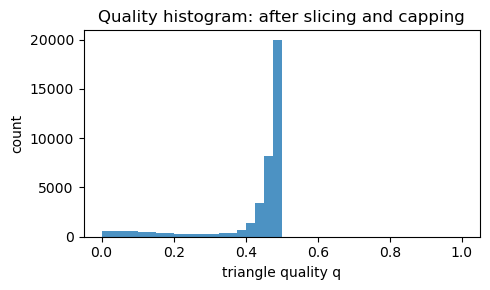

[quick 0 1/2] 19816 verts, 39760 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.021, components: 1
[quick 0 2/2] vol = 0.2283427691970301, area = 6.998647419141045, non-manifold edges: 0/ vertices: 0


Widget(value='<iframe src="http://localhost:38537/index.html?ui=P_0x7efdd43f0c90_9&reconnect=auto" class="pyvi…

In [26]:
import trimesh 

d = 0.01

x_plane_min_normal = (1,0,0)
x_plane_min_point = (d,0,0)
x_plane_max_normal = (-1,0,0)
x_plane_max_point = (1-d,0,0)

y_plane_min_normal = (0,1,0)
y_plane_min_point = (0,d,0)
y_plane_max_normal = (0,-1,0)
y_plane_max_point = (0,1-d,0)   

z_plane_min_normal = (0,0,1)
z_plane_min_point = (0,0,d)
z_plane_max_normal = (0,0,-1)
z_plane_max_point = (0,0,1-d)

normalized_mesh = trimesh.Trimesh(normalized_nodes, clean_elems2)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(normalized_nodes, clean_elems2))
quick_mesh_report(ms0, i=0)
del ms0

engine = "triangle" # "triangle" # "manifold", "earcut"

# consecutive slicing and capping
normalized_mesh_sliced_x_min = normalized_mesh.slice_plane(x_plane_min_point, x_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after x min slice: {normalized_mesh_sliced_x_min.vertices.shape}")
normalized_mesh_sliced_x_max = normalized_mesh_sliced_x_min.slice_plane(x_plane_max_point, x_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after x max slice: {normalized_mesh_sliced_x_max.vertices.shape}")
normalized_mesh_sliced_y_min = normalized_mesh_sliced_x_max.slice_plane(y_plane_min_point, y_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after y min slice: {normalized_mesh_sliced_y_min.vertices.shape}")
normalized_mesh_sliced_y_max = normalized_mesh_sliced_y_min.slice_plane(y_plane_max_point, y_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after y max slice: {normalized_mesh_sliced_y_max.vertices.shape}")
normalized_mesh_sliced_z_min = normalized_mesh_sliced_y_max.slice_plane(z_plane_min_point, z_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after z min slice: {normalized_mesh_sliced_z_min.vertices.shape}")
normalized_mesh_sliced_all = normalized_mesh_sliced_z_min.slice_plane(z_plane_max_point, z_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after z max slice: {normalized_mesh_sliced_all.vertices.shape}")

# normalize again
# normalized_mesh_sliced_all = trimesh.Trimesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces)
normalized_mesh_sliced_all.vertices = (normalized_mesh_sliced_all.vertices - normalized_mesh_sliced_all.vertices.min(axis=0)) / (normalized_mesh_sliced_all.vertices.max(axis=0) - normalized_mesh_sliced_all.vertices.min(axis=0))

mesh_report(normalized_mesh_sliced_all, name="after slicing and capping", plot=True)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
quick_mesh_report(ms0, i=0)
del ms0

view_surface(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces, title="normalized")

In [35]:
# i2m remesh
# print(f"[I2M RESAMPLING]")
# flattened_nodes_resampled, flattened_elems_resampled = i2m.meshresample(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces+1, 0.99)
# # mesh_report(trimesh.Trimesh(*matlab_to_python_conv(clean_nodes_resampled, clean_elems_resampled)), name="after i2m resample", plot=True)
# view_surface(*matlab_to_python_conv(flattened_nodes_resampled, flattened_elems_resampled), title="v2m unique faces")
# ms0 = ml.MeshSet()
# ms0.add_mesh(ml.Mesh(*matlab_to_python_conv(flattened_nodes_resampled, flattened_elems_resampled)))
# quick_mesh_report(ms0, i=0)
# del ms0


=== flat input: geometric/graph checks START ===
trimesh metrics:
mesh is_winding_consistent? True
mesh is_watertight? True
verts=19,816, faces=39,760
bbox min=[0. 0. 0.], max=[1. 1. 1.], extents=[1. 1. 1.]
surface area = 6.99865
enclosed volume (watertight) = 0.228343
h (edge length): min=8.178e-06, mean=0.02089, max=0.221
duplicate faces: 0, duplicate vertices (<= 1e-12): 0
== pymeshlab metrics:
Geometric measures:
  avg_edge_length: 0.020887557896204438
  surface_area: 6.998647212982178
Topological measures:
  boundary_edges: 0
  connected_components_number: 1
  edges_number: 59640
  faces_number: 39760
  genus: 33
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 0
  vertices_number: 19816
== custom metrics:
triangle quality q in [0,1] (equilateral=1): min=0.000, p5=0.085, mean=0.424, p95=0.498, max=0.500


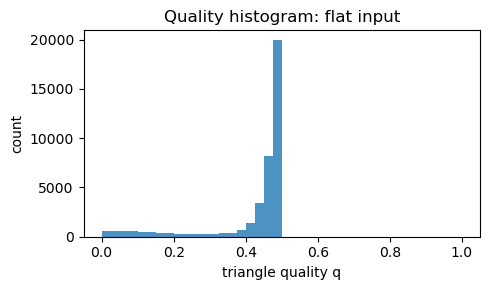

In [27]:
stats0 = mesh_report(normalized_mesh_sliced_all, name="flat input", plot=True)

target length percentage: 1.0%
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE FACES]
[quick 0 1/2] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[REMOVING NULL FACES]
[quick 0 1/2] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[REMOVING UNREFERENCED VERTICES]
[quick 0 1/2] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edg

Widget(value='<iframe src="http://localhost:38537/index.html?ui=P_0x7efdd43eeb50_11&reconnect=auto" class="pyv…


=== after remeshing: geometric/graph checks START ===
trimesh metrics:
mesh is_winding_consistent? True
mesh is_watertight? True
verts=26,906, faces=53,940
bbox min=[0. 0. 0.], max=[1. 1. 1.], extents=[1. 1. 1.]
surface area = 6.96926
enclosed volume (watertight) = 0.22826
h (edge length): min=3.248e-05, mean=0.01751, max=0.03632
duplicate faces: 0, duplicate vertices (<= 1e-12): 0
== pymeshlab metrics:
Geometric measures:
  avg_edge_length: 0.017509911446975
  surface_area: 6.96925687789917
Topological measures:
  boundary_edges: 0
  connected_components_number: 1
  edges_number: 80910
  faces_number: 53940
  genus: 33
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 0
  vertices_number: 26906
== custom metrics:
triangle quality q in [0,1] (equilateral=1): min=0.001, p5=0.395, mean=0.468, p95=0.499, max=0.500


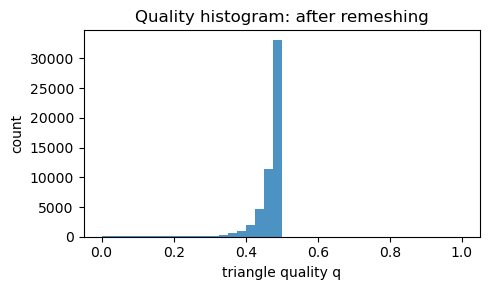

In [31]:
h_cap = 0.01
iterations = 6  
ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
print(f"target length percentage: {h_cap*100:.1f}%")
ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
                                        iterations=iterations,
                                        adaptive=False,
                                        reprojectflag=True
                                        )

heal(ms)

trimesh_remeshed_full = trimesh.Trimesh(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()))

view_surface(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()), title="after remeshing")
stats1 = mesh_report(trimesh_remeshed_full, name="after remeshing", plot=True)

## Fusing - part 1

In [32]:
def view_wireframe(V: np.ndarray, F: np.ndarray, title="surface"):
    faces = np.hstack([np.full((len(F),1),3), F]).ravel()
    mesh = pv.PolyData(V, faces)
    p = pv.Plotter()
    p.add_mesh(mesh, show_edges=True, color='black', style='wireframe')
    p.add_axes(); p.show(title=title)

In [33]:
def normalize_vertices(V: np.ndarray) -> np.ndarray:
    return (V - V.min(axis=0)) / (V.max(axis=0) - V.min(axis=0))

In [ ]:
# first fuse only in x direction. reflect as 2x-1. 

quick_mesh_report(ms, i=0)

V0 = np.asarray(trimesh_remeshed_full.vertices, float)
V0 = np.stack((V0[:,0]+1e-2, V0[:,1]+1e-2, V0[:,2]+1e-2), axis=-1)
F0 = np.asarray(trimesh_remeshed_full.faces,    int)

# V0 = normalize_vertices(V0)

print(f"bounding box: min={V0.min(axis=0)}, max={V0.max(axis=0)}")

shift_x = np.array([2,0,0], float)
V0x = np.stack((2 - V0[:,0]-2e-2, V0[:,1], V0[:,2]), axis=-1)
print(f"bounding box after shift in x: min={V0x.min(axis=0)}, max={V0x.max(axis=0)}")
assert V0.shape == V0x.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0x, F0))
ms_reflected.meshing_invert_face_orientation()
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
x_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_x_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, x_trimesh_mesh])
print("fused in x direction")
# mesh_report(orig_x_trimesh_mesh, name="after fusing in x - blender", plot=True)
orig_x_ms = ml.MeshSet()
orig_x_ms.add_mesh(ml.Mesh(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces))
quick_mesh_report(orig_x_ms, i=0)
heal(orig_x_ms)
# quick_mesh_report(orig_x_ms, i=0)


print(f"bounding box after fusing in x: min={orig_x_trimesh_mesh.vertices.min(axis=0)}, max={orig_x_trimesh_mesh.vertices.max(axis=0)}")

view_surface(orig_x_ms.current_mesh().vertex_matrix(), orig_x_ms.current_mesh().face_matrix(), title="after fusing in x - remeshlab", plane=True, planepoint=[1,0.5,0.5], planenormal=[1,0,0])
view_wireframe(orig_x_ms.current_mesh().vertex_matrix(), orig_x_ms.current_mesh().face_matrix(), title="after fusing in x - remeshlab wireframe")
# view_surface(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces, title="after fusing in x - blender")
# view_wireframe(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces, title="after fusing in x - wireframe")

[quick 0 1/2] 28344 verts, 56816 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/2] vol = 0.22016620085543714, area = 7.195471422623858, non-manifold edges: 0/ vertices: 0
bounding box: min=[0.01000559 0.01       0.01      ], max=[1.00995733 1.01       1.01      ]
bounding box after shift in x: min=[0.97004267 0.01       0.01      ], max=[1.96999441 1.01       1.01      ]
[quick 0 1/2] 28344 verts, 56816 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/2] vol = 0.22016620085543712, area = 7.195471422623858, non-manifold edges: 0/ vertices: 0
fused in x direction
[quick 0 1/2] 57449 verts, 115154 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/2] vol = 0.43040387577678957, area = 13.674880220648744, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 57449 verts, 115154 faces, watertight: True, genus: 65, wind-consistent: 

Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7fb5401b2f10_11&reconnect=auto" class="pyv…

A view with name (P_0x7fb5401b2f10_11) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7fb5401b2f10_11&reconnect=auto" class="pyv…

Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7fb4b4129e50_12&reconnect=auto" class="pyv…

In [28]:
# fuse in y direction

quick_mesh_report(orig_x_ms, i=0)

V0 = np.asarray(orig_x_ms.current_mesh().vertex_matrix(), float)
F0 = np.asarray(orig_x_ms.current_mesh().face_matrix(), int)

shift_y = np.array([0,2,0], float)
V0x = np.stack((V0[:,0], 2 - V0[:,1] - 2e-2, V0[:,2]), axis=-1)
assert V0.shape == V0x.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0x, F0))
ms_reflected.meshing_invert_face_orientation()
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
y_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_y_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, y_trimesh_mesh])
print("fused in y direction")
orig_y_ms = ml.MeshSet()
orig_y_ms.add_mesh(ml.Mesh(orig_y_trimesh_mesh.vertices, orig_y_trimesh_mesh.faces))
quick_mesh_report(orig_y_ms, i=0)
heal(orig_y_ms)
# orig_y_ms.meshing_merge_close_vertices(threshold = ml.PercentageValue(0.1 * 100))
# quick_mesh_report(orig_y_ms, i=1)

view_surface(orig_y_trimesh_mesh.vertices, orig_y_trimesh_mesh.faces, title="after fusing in y - blender", plane=True, planepoint=[0.5,1,0.5], planenormal=[0,1,0])

[quick 0 1/2] 57449 verts, 115154 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/2] vol = 0.43040387577678957, area = 13.674880220648744, non-manifold edges: 0/ vertices: 0
[quick 0 1/2] 57449 verts, 115154 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/2] vol = 0.43040387577678957, area = 13.674880220648744, non-manifold edges: 0/ vertices: 0
fused in y direction
[quick 0 1/2] 114806 verts, 230132 faces, watertight: True, genus: 132, wind-consistent: True, h = 0.016, components: 2
[quick 0 2/2] vol = 0.852723523626727, area = 26.643220387964348, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 114806 verts, 230132 faces, watertight: True, genus: 132, wind-consistent: True, h = 0.016, components: 2
[quick 0 2/2] vol = 0.852723523626727, area = 26.643220387964348, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE FACES]
[quick 0 1/2] 114806 verts, 230132 fac

Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7fb38c1ed410_18&reconnect=auto" class="pyv…

A view with name (P_0x7fb38c1ed410_18) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:44993/index.html?ui=P_0x7fb38c1ed410_18&reconnect=auto" class="pyv…

In [ ]:
# fuse in z direction

quick_mesh_report(orig_y_ms, i=0)

V0 = np.asarray(orig_y_trimesh_mesh.vertices, float)
F0 = np.asarray(orig_y_trimesh_mesh.faces,    int)

shift_z = np.array([0,0,2], float)
V0x = np.stack((V0[:,0], V0[:,1], 2 - V0[:,2] - 2e-2), axis=-1)
assert V0.shape == V0x.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0x, F0))
ms_reflected.meshing_invert_face_orientation()
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
z_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_z_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, z_trimesh_mesh])
print("fused in z direction")
orig_z_ms = ml.MeshSet()
orig_z_ms.add_mesh(ml.Mesh(orig_z_trimesh_mesh.vertices, orig_z_trimesh_mesh.faces))
heal(orig_z_ms)
quick_mesh_report(orig_z_ms, i=0)
# orig_z_ms.meshing_merge_close_vertices(threshold = ml.PercentageValue(0.1 * 100))
# quick_mesh_report(orig_z_ms, i=1)

view_surface(orig_z_trimesh_mesh.vertices, orig_z_trimesh_mesh.faces, title="after fusing in z - blender")

[quick 0 1/2] 114542 verts, 229612 faces, watertight: True, genus: 134, wind-consistent: True, h = 0.016, components: 2
[quick 0 2/2] vol = 0.848846175946555, area = 26.547188635069325, non-manifold edges: 0/ vertices: 0
[quick 0 1/2] 114542 verts, 229612 faces, watertight: True, genus: 134, wind-consistent: True, h = 0.016, components: 2
[quick 0 2/2] vol = 0.848846175946555, area = 26.547188635069325, non-manifold edges: 0/ vertices: 0
fused in z direction
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 230076 verts, 461256 faces, watertight: True, genus: 279, wind-consistent: True, h = 0.016, components: 3
[quick 0 2/2] vol = 1.687510139683224, area = 51.492788020416555, non-manifold edges: 0/ vertices: 0
[REMOVING DUPLICATE FACES]


In [ ]:
import json
from collections import defaultdict

def periodic_node_map_from_planes(mesh_single: trimesh.Trimesh,
                                  tol: float = 1e-12) -> dict:
    """
    Build exact node maps between opposite planes by coordinate equality.
    Returns dict with keys 'x','y','z' each mapping to list of [slave_idx, master_idx].
    Assumes mesh_single is already flattened to x=0/1, y=0/1, z=0/1.
    """
    V = mesh_single.vertices.view(np.ndarray)
    eps = tol

    def plane_pairs(axis, v0, v1):
        a = {'x':0, 'y':1, 'z':2}[axis]
        other = [i for i in range(3) if i != a]
        I0 = np.where(np.isclose(V[:,a], v0, atol=eps))[0]
        I1 = np.where(np.isclose(V[:,a], v1, atol=eps))[0]
        if len(I0) != len(I1):
            print(f"[periodic] {axis}: count mismatch: {len(I0)} vs {len(I1)}")
        # match by the other two coordinates
        key = lambda p: (round(V[p,other[0]]/eps)*eps, round(V[p,other[1]]/eps)*eps)
        m0 = defaultdict(list)
        for i in I0: m0[key(i)].append(i)
        pairs = []
        for j in I1:
            k = key(j)
            if k not in m0 or len(m0[k]) == 0:
                # fallback: nearest neighbor among I0 on the plane
                P0 = V[I0][:,other]
                idx = np.argmin(np.linalg.norm(P0 - V[j,other], axis=1))
                pairs.append([int(j), int(I0[idx])])
            else:
                pairs.append([int(j), int(m0[k].pop())])
        # sanity
        slave = V[[p[0] for p in pairs]]
        master = V[[p[1] for p in pairs]].copy()
        master[:,a] = v1  # so that slave and transformed master are identical
        err = np.max(np.abs(slave - master))
        print(f"[periodic] {axis}-map pairs={len(pairs)}, max |slave-master| = {err:.3e}")
        return pairs

    maps = {
        'x': plane_pairs('x', 0.0, 1.0),
        'y': plane_pairs('y', 0.0, 1.0),
        'z': plane_pairs('z', 0.0, 1.0),
    }
    return maps

def save_periodic_map_json(maps: dict, path: str):
    with open(path, "w") as f:
        json.dump(maps, f, indent=2)
    print(f"[periodic] saved node map to {path}")


In [39]:

def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2); 1 = equilateral
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0*e0 + e1*e1 + e2*e2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)

def _as_ml_mesh(m: trimesh.Trimesh) -> ml.Mesh:
    return ml.Mesh(np.asarray(m.vertices, float), np.asarray(m.faces, int))

def _from_ml_mesh(m: ml.Mesh) -> trimesh.Trimesh:
    return trimesh.Trimesh(
        vertices=np.asarray(m.vertex_matrix(), float),
        faces=np.asarray(m.face_matrix(), int),
        process=False
    )

# def _manifold_edge_stats(tm: trimesh.Trimesh):
#     # edges_unique_faces: object array of lists (each list = incident faces indices)
#     e_faces = tm.edges_unique_faces
#     bnd = sum(1 for ef in e_faces if len(ef) == 1)
#     nonman = sum(1 for ef in e_faces if len(ef) > 2)
#     return bnd, nonman

def _genus(tm: trimesh.Trimesh):
    # Only meaningful if watertight and orientable
    if not tm.is_watertight:
        return None
    # euler_number present in trimesh
    chi = tm.euler_number
    # For single closed orientable surface: chi = 2 - 2g -> g = (2 - chi)/2
    return (2 - chi)/2

def _print_trimesh_stats(tm: trimesh.Trimesh, label: str, plot_quality_hist=False):
    V = tm.vertices; F = tm.faces
    print(f"\n=== {label} (trimesh diagnostics) ===")
    print(f"verts={len(V):,} faces={len(F):,}")
    print(f"bbox min={tm.bounds[0]}  max={tm.bounds[1]}  extents={tm.extents}")
    print(f"surface area={tm.area:.6g}")
    if tm.is_watertight:
        print(f"volume={tm.volume:.6g}")
    else:
        print("volume=N/A (not watertight)")
    # bnd, nonman = _manifold_edge_stats(tm)
    print(f"watertight={tm.is_watertight}  winding_consistent={tm.is_winding_consistent}")
    # print(f"boundary_edges={bnd}  nonmanifold_edges={nonman}")
    g = _genus(tm)
    print(f"genus={g if g is not None else 'N/A'}  euler_number={tm.euler_number}")
    # duplicates
    sF = np.sort(F, axis=1)
    _, idx = np.unique(sF, axis=0, return_index=True)
    dup_faces = len(F) - len(idx)
    key = np.round(V/1e-12).astype(np.int64)
    _, vidx = np.unique(key, axis=0, return_index=True)
    dup_verts = len(V) - len(vidx)
    print(f"duplicate_faces={dup_faces} duplicate_vertices(1e-12 snap)={dup_verts}")
    # quality
    q = _triangle_quality(V, F)
    qs = dict(
        min=float(q.min()),
        p5=float(np.percentile(q,5)),
        mean=float(q.mean()),
        p95=float(np.percentile(q,95)),
        max=float(q.max())
    )
    print("triangle_quality q: "
          f"min={qs['min']:.3f} p5={qs['p5']:.3f} mean={qs['mean']:.3f} "
          f"p95={qs['p95']:.3f} max={qs['max']:.3f}")
    if plot_quality_hist:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q")
        plt.ylabel("count")
        plt.title(f"Quality: {label}")
        plt.tight_layout()
        plt.show()
    return {
        "verts": len(V),
        "faces": len(F),
        "watertight": tm.is_watertight,
        # "boundary_edges": bnd,
        # "nonmanifold_edges": nonman,
        "genus": g,
        "euler_number": tm.euler_number
    }

def _pml_measures(ms: ml.MeshSet, label: str):
    g = ms.get_geometric_measures()
    t = ms.get_topological_measures()
    print(f"\n--- {label} (PyMeshLab measures) ---")
    for k,v in g.items():
        print(f"[geo] {k}: {v}")
    for k,v in t.items():
        print(f"[topo] {k}: {v}")
    return g, t

def _weld_trimesh(tm: trimesh.Trimesh, weld_abs: float):
    V = tm.vertices.copy()
    F = tm.faces.copy()
    if weld_abs <= 0:
        return tm
    key = np.round(V / weld_abs).astype(np.int64)
    _, keep, inv = np.unique(key, axis=0, return_index=True, return_inverse=True)
    Vw = V[keep]
    Fw = inv[F]
    # remove degenerate & duplicate
    keepf = (Fw[:,0]!=Fw[:,1]) & (Fw[:,0]!=Fw[:,2]) & (Fw[:,1]!=Fw[:,2])
    Fw = Fw[keepf]
    sF = np.sort(Fw,axis=1)
    _, uidx = np.unique(sF, axis=0, return_index=True)
    Fw = Fw[np.sort(uidx)]
    return trimesh.Trimesh(Vw, Fw, process=False)

def _pair_planes(mesh: trimesh.Trimesh, axis: str, L: float, tol: float, quant: float):
    a = {'x':0,'y':1,'z':2}[axis]
    other = [i for i in range(3) if i != a]
    V = mesh.vertices
    I0 = np.where(np.isclose(V[:,a], 0.0, atol=tol))[0]
    I2 = np.where(np.isclose(V[:,a], L,   atol=tol))[0]
    def key(i):
        return (int(round(V[i,other[0]]/quant)),
                int(round(V[i,other[1]]/quant)))
    buckets = {}
    for i in I0:
        buckets.setdefault(key(i), []).append(i)
    pairs=[]
    missed=0
    for j in I2:
        k = key(j)
        if k in buckets and buckets[k]:
            pairs.append([buckets[k].pop(), j])  # [min_plane, max_plane]
        else:
            missed+=1
            # fallback nearest
            if len(I0):
                d = np.linalg.norm(V[I0][:,other]-V[j,other], axis=1)
                pairs.append([I0[np.argmin(d)], j])
    print(f"[pair {axis}] pairs={len(pairs)} fallback={missed} I0={len(I0)} I{L}={len(I2)}")
    return pairs

# ---------- Main Function ----------


## Route 2

In [35]:
def meshset_to_trimesh(ms: ml.MeshSet) -> trimesh.Trimesh:
    cm = ms.current_mesh()
    return trimesh.Trimesh(
        vertices=np.asarray(cm.vertex_matrix(), float),
        faces=np.asarray(cm.face_matrix(), int),
        process=False
    )

In [34]:
# h_cap = 0.01
# iterations = 6
# m1 = m.copy()
# V, F = m1.vertices.copy(), m1.faces.copy()
# ms = ml.MeshSet()
# ms.add_mesh(ml.Mesh(V, F))
# print(f"target length percentage: {h_cap*100:.1f}%")
# ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
#                                         iterations=iterations,
#                                         adaptive=False,
#                                         reprojectflag=True
#                                         )
# mesh_report(meshset_to_trimesh(ms), name="remeshed mesh", plot=True)
# heal(ms)
# mesh_report(meshset_to_trimesh(ms), name="healed mesh", plot=True)

# Route 3 - reflect and stitch

In [36]:
def _snap_plane_coords(V, axis, plane_value, tol=1e-9):
    a = {'x':0,'y':1,'z':2}[axis]
    V = V.copy()
    mask = np.isclose(V[:,a], plane_value, atol=tol)
    V[mask, a] = plane_value
    return V

def _stitch_two_meshes_along_plane(VA, FA, VB, FB, axis='x', plane_value=1.0, tol=1e-9, quant=1e-6):
    """
    Weld VB/FB into VA/FA by reusing VA's on-plane vertices on the plane `axis=plane_value`.
    Returns fused (V, F). Does not run any smoothing or booleans.
    """
    a = {'x':0,'y':1,'z':2}[axis]
    other = [i for i in range(3) if i != a]

    # 1) snap both to the exact plane value
    VA = _snap_plane_coords(VA, axis, plane_value, tol)
    VB = _snap_plane_coords(VB, axis, plane_value, tol)

    # 2) collect on-plane vertex indices
    IA = np.where(np.isclose(VA[:,a], plane_value, atol=tol))[0]
    IB = np.where(np.isclose(VB[:,a], plane_value, atol=tol))[0]

    # 3) build quantized keys for tangential coords
    def key2d(P):
        return tuple((np.round(P/quant)).astype(np.int64))

    buckets = {}
    for i in IA:
        buckets.setdefault(key2d(VA[i,other]), []).append(i)

    # 4) build a map B->A for the on-plane vertices
    mapB = -np.ones(len(VB), dtype=np.int64)
    fallback = 0
    for j in IB:
        k = key2d(VB[j,other])
        if k in buckets and buckets[k]:
            mapB[j] = buckets[k].pop()
        else:
            # small nearest-neighbor fallback among IA on the plane
            if len(IA):
                d = np.linalg.norm(VA[IA][:,other] - VB[j,other], axis=1)
                mapB[j] = IA[int(np.argmin(d))]
                fallback += 1
    if fallback:
        print(f"[stitch] {fallback} on-plane vertices matched via nearest-neighbor fallback.")

    # 5) append off-plane B vertices to A
    new_ids = np.arange(len(VA), len(VA) + len(VB), dtype=np.int64)
    off_plane = np.ones(len(VB), dtype=bool)
    off_plane[IB] = False
    # also any on-plane B not mapped (rare) will be appended
    not_mapped = (mapB < 0)
    append_mask = off_plane | not_mapped
    VB_append = VB[append_mask]
    VA_out = np.vstack([VA, VB_append])

    # 6) build the full B->A mapping array
    mapB_full = np.empty(len(VB), dtype=np.int64)
    # for mapped on-plane
    mapped_mask = (mapB >= 0)
    mapB_full[mapped_mask] = mapB[mapped_mask]
    # for the rest (append)
    next_id = len(VA)
    for j in np.where(~mapped_mask)[0]:
        mapB_full[j] = next_id
        next_id += 1
    assert next_id == len(VA_out)

    # 7) remap B faces and concatenate
    FBm = mapB_full[FB]
    F_out = np.vstack([FA, FBm])

    # 8) clean up degenerate and duplicate faces
    keep = (F_out[:,0]!=F_out[:,1]) & (F_out[:,0]!=F_out[:,2]) & (F_out[:,1]!=F_out[:,2])
    F_out = F_out[keep]
    sF = np.sort(F_out, axis=1)
    _, uidx = np.unique(sF, axis=0, return_index=True)
    F_out = F_out[np.sort(uidx)]

    return VA_out, F_out

def reflect_and_stitch(mesh: trimesh.Trimesh, axis='x', plane_value=1.0, domain_L=2.0, tol=1e-9, quant=1e-6):
    """
    Reflect `mesh` across plane `axis=plane_value` via coord -> (2*plane_value - coord),
    flip face winding on the reflected copy, then stitch along the plane.
    """
    a = {'x':0,'y':1,'z':2}[axis]
    V0 = mesh.vertices.copy()
    F0 = mesh.faces.copy()

    Vr = V0.copy()
    Vr[:, a] = 2.0*plane_value - Vr[:, a]
    Fr = F0[:, [0,2,1]]  # flip orientation for single reflection

    # IMPORTANT: remove any artificial offsets — exact snapping is required
    V0 = _snap_plane_coords(V0, axis, plane_value, tol)
    Vr = _snap_plane_coords(Vr, axis, plane_value, tol)

    VA, FA = _stitch_two_meshes_along_plane(V0, F0, Vr, Fr, axis=axis, plane_value=plane_value, tol=tol, quant=quant)
    tm = trimesh.Trimesh(VA, FA, process=False)
    tm.remove_unreferenced_vertices()
    return tm

[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 52536 verts, 105747 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = None, area = 13.669021396312768, non-manifold edges: 1257/ vertices: 0
[REMOVING DUPLICATE FACES]
[quick 0 1/2] 52536 verts, 105747 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = None, area = 13.669021396312768, non-manifold edges: 1257/ vertices: 0
[REMOVING NULL FACES]
[quick 0 1/2] 52536 verts, 105747 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = None, area = 13.669021396312768, non-manifold edges: 1257/ vertices: 0
[REMOVING UNREFERENCED VERTICES]
[quick 0 1/2] 52536 verts, 105747 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = None, area = 13.669021396312768, non-manifold edges: 1257/ vertices: 0
[REPAIRING NON-MANIFOLD EDGES]
[quick 0 1/2] 525

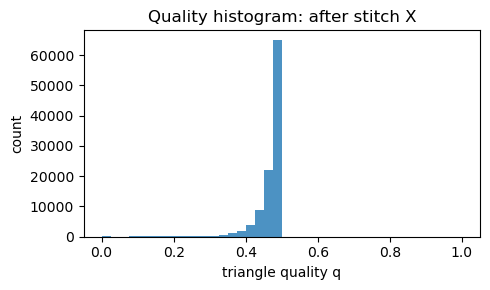

In [40]:
mesh_x  = reflect_and_stitch(trimesh_remeshed_full, axis='x', plane_value=1.0, tol=1e-9, quant=1e-6)
mx = ml.MeshSet()
mx.add_mesh(_as_ml_mesh(mesh_x))
heal(mx)
stats_x = mesh_report(meshset_to_trimesh(mx), name="after stitch X", plot=True)

# mesh_xy  = reflect_and_stitch(mesh_x, axis='y', plane_value=1.0, tol=1e-9, quant=1e-6)
# stats_xy = mesh_report(mesh_xy, name="after stitch XY", plot=True)

# mesh_xyz  = reflect_and_stitch(mesh_xy, axis='z', plane_value=1.0, tol=1e-9, quant=1e-6)
# stats_xyz = mesh_report(mesh_xyz, name="after stitch XYZ", plot=True)

# view_surface(mesh_xyz.vertices, mesh_xyz.faces, title="2x2x2 stitched")

# Route 4

In [53]:
def fuse_2x2x2_by_reflection_simple(
    mesh: trimesh.Trimesh,
    plane_snap: float = 1e-9,  # snap any coord within this to exact 0/1
    weld_tol:   float = 5e-9,  # hashing tolerance for welding verts
    verbose:    bool = True,
    normalize_to_unit: bool = True
) -> trimesh.Trimesh:
    """
    Build a 2×2×2 reflection tiling, weld coincident vertices, drop duplicate faces.
    No booleans, no retessellation. This is the MATLAB-style 'append + weld + dedup'.

    Assumes 'mesh' is a single watertight RVE within a box ~[0,1]^3.
    """

    V0 = mesh.vertices.copy()
    F0 = mesh.faces.copy()

    # 0) normalize and SNAP box planes to EXACT 0/1
    if normalize_to_unit:
        vmin = V0.min(0); vmax = V0.max(0); ext = np.where((vmax-vmin)==0, 1.0, vmax-vmin)
        V0 = (V0 - vmin)/ext

    # snap any values near 0 or 1 to exactly 0/1
    def _snap01(a):
        a = np.where(np.isclose(a, 0.0, atol=plane_snap), 0.0, a)
        a = np.where(np.isclose(a, 1.0, atol=plane_snap), 1.0, a)
        return a
    V0[:,0], V0[:,1], V0[:,2] = _snap01(V0[:,0]), _snap01(V0[:,1]), _snap01(V0[:,2])

    # 1) build the 8 reflected tiles (flip winding for odd # of reflections)
    Vtiles, Ftiles = [], []
    offset = 0
    for rx in (0,1):
        for ry in (0,1):
            for rz in (0,1):
                Vi = V0.copy()
                if rx: Vi[:,0] = 2.0 - Vi[:,0]
                if ry: Vi[:,1] = 2.0 - Vi[:,1]
                if rz: Vi[:,2] = 2.0 - Vi[:,2]
                Fi = F0[:, [0,2,1]] if ((rx + ry + rz) & 1) else F0
                Vtiles.append(Vi)
                Ftiles.append(Fi + offset)
                offset += len(Vi)
                if verbose:
                    bbmin, bbmax = Vi.min(0), Vi.max(0)
                    print(f"[tile] reflect rx={rx} ry={ry} rz={rz} | bbox min={bbmin}, max={bbmax}")

    Vall = np.vstack(Vtiles)
    Fall = np.vstack(Ftiles)
    if verbose:
        print(f"[stack] pre-weld V={len(Vall):,}, F={len(Fall):,}")

    # 2) weld: hash vertices at weld_tol so seam points share the same ID
    Q = np.round(Vall / weld_tol).astype(np.int64)
    U, idx, inv = np.unique(Q, axis=0, return_index=True, return_inverse=True)
    Vw = Vall[idx]
    Fw = inv[Fall]

    # 3) remove degenerate and duplicate faces (order-insensitive)
    keep = (Fw[:,0]!=Fw[:,1]) & (Fw[:,1]!=Fw[:,2]) & (Fw[:,2]!=Fw[:,0])
    Fw = Fw[keep]
    Fs = np.sort(Fw, axis=1)
    _, uniq_idx = np.unique(Fs, axis=0, return_index=True)
    Fw = Fw[np.sort(uniq_idx)]

    # 4) final snap on seams to kill 1±ε drift after weld; build mesh
    for a in range(3):
        Vw[:,a] = np.where(np.isclose(Vw[:,a], 1.0, atol=plane_snap), 1.0, Vw[:,a])
        Vw[:,a] = np.where(np.isclose(Vw[:,a], 0.0, atol=plane_snap), 0.0, Vw[:,a])

    fused = trimesh.Trimesh(vertices=Vw, faces=Fw, process=False)

    if verbose:
        comps = fused.split(only_watertight=False)
        print(f"[fused] V={len(Vw):,}, F={len(Fw):,}, components={len(comps)}, watertight={fused.is_watertight}")
    return fused

In [54]:
# 1) sanity on the single-cell surface
ms0 = ml.MeshSet(); ms0.add_mesh(ml.Mesh(trimesh_remeshed_full.vertices, trimesh_remeshed_full.faces))
quick_mesh_report(ms0, i=0)  # expect watertight=True, components=1

# 2) fuse by reflection (tolerances you can tune)
mesh_2x2x2 = fuse_2x2x2_by_reflection_simple(
    trimesh_remeshed_full,
    plane_snap=1e-9,   # if seams show "bad edges", increase to 5e-9
    weld_tol=5e-9,
    normalize_to_unit=True,
    verbose=True
)

# 3) small clean using your existing helper
ms = ml.MeshSet(); ms.add_mesh(ml.Mesh(mesh_2x2x2.vertices, mesh_2x2x2.faces))
heal(ms)                     # your heal() as posted
quick_mesh_report(ms, i=0)   # should say watertight=True, components=1
view_surface(np.asarray(ms.current_mesh().vertex_matrix()),
             np.asarray(ms.current_mesh().face_matrix(), int),
             title="2×2×2 fused (reflect+weld)")

[quick 0 1/2] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/2] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[tile] reflect rx=0 ry=0 rz=0 | bbox min=[0. 0. 0.], max=[1. 1. 1.]
[tile] reflect rx=0 ry=0 rz=1 | bbox min=[0. 0. 1.], max=[1. 1. 2.]
[tile] reflect rx=0 ry=1 rz=0 | bbox min=[0. 1. 0.], max=[1. 2. 1.]
[tile] reflect rx=0 ry=1 rz=1 | bbox min=[0. 1. 1.], max=[1. 2. 2.]
[tile] reflect rx=1 ry=0 rz=0 | bbox min=[1. 0. 0.], max=[2. 1. 1.]
[tile] reflect rx=1 ry=0 rz=1 | bbox min=[1. 0. 1.], max=[2. 1. 2.]
[tile] reflect rx=1 ry=1 rz=0 | bbox min=[1. 1. 0.], max=[2. 2. 1.]
[tile] reflect rx=1 ry=1 rz=1 | bbox min=[1. 1. 1.], max=[2. 2. 2.]
[stack] pre-weld V=215,248, F=431,520
[fused] V=203,992, F=412,864, components=60, watertight=False
[REMOVING DUPLICATE VERTICES]
[quick 0 1/2] 203992 verts, 412864 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, c

Widget(value='<iframe src="http://localhost:38537/index.html?ui=P_0x7efd580aa450_20&reconnect=auto" class="pyv…

In [ ]:
# count vertices *near* x=1, and exactly on x=1 after snap
V = mesh_2x2x2.vertices
near_x1 = np.sum(np.isclose(V[:,0], 1.0, atol=5e-9))
exact_x1 = np.sum(np.isclose(V[:,0], 1.0, atol=0.0))
print("[seam] near x=1:", near_x1, "exact x=1:", exact_x1)

[seam] near x=1: 5068 exact x=1: 5068
[seam] x=1 edge count≠2: 1646
